In [1]:
# Install required packages
!pip install geopy

     |████████████████████████████████| 118 kB 611 kB/s eta 0:00:01


In [92]:
# Import python packages
# from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as Math
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score,precision_score, recall_score, roc_auc_score, classification_report,plot_roc_curve 
from sklearn.preprocessing import LabelEncoder

In [4]:
# Load raw data from cvs
#https://www.kaggle.com/datasets/shashwatwork/dataco-smart-supply-chain-for-big-data-analysis
dataset=pd.read_csv('/Users/kpathak/Downloads/DataCoSmartSupplychain/DataCoSupplyChainDataset.csv',encoding='iso-8859-1')


In [8]:
dataset.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [5]:
# dataset information
def data_info(dataset):
    print('1) Number of columns are : ',dataset.shape[1])
    print('2) Number of rows are : ',dataset.shape[0])
    print('3) Total number of data-points :',dataset.size)
    numerical_features = [f for f in dataset.columns if dataset[f].dtypes!='O']
    print('4) Count of Numerical Features :',len(numerical_features))
    cat_features = [c for c in dataset.columns if dataset[c].dtypes=='O']
    print('5) Count of Categorical Features :',len(cat_features))
data_info(dataset)

1) Number of columns are :  53
2) Number of rows are :  180519
3) Total number of data-points : 9567507
4) Count of Numerical Features : 29
5) Count of Categorical Features : 24


In [6]:
# Checking missing values and data type of each features
pd.DataFrame.from_dict({'columns':[i for i in dataset.columns], 
                        'nulls':[sum(dataset[i].isnull()) for i in dataset.columns], 
                        'dtype': [dataset[i].dtype for i in dataset.columns]})

,columns,nulls,dtype
0,Type,0,object
1,Days for shipping (real),0,int64
2,Days for shipment (scheduled),0,int64
3,Benefit per order,0,float64
4,Sales per customer,0,float64
5,Delivery Status,0,object
6,Late_delivery_risk,0,int64
7,Category Id,0,int64
8,Category Name,0,object
9,Customer City,0,object


In [10]:
# Dropping columns with null values
# dataset = dataset.drop(columns = ["Order_Zipcode", "Product_Description"])

In [11]:
# To describe the dataset
dataset.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180516.000000,180519.000000,180519.000000,...,180519.000000,180519.000000,180519.000000,180519.000000,24840.000000,180519.000000,180519.000000,0.0,180519.000000,180519.0
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,6691.379495,35921.126914,5.443460,29.719955,...,2.127638,203.772096,183.107609,21.974989,55426.132327,692.509764,31.851451,NaN,141.232550,0.0
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,4162.918106,37542.461122,1.629246,9.813646,...,1.453451,132.273077,120.043670,104.433526,31919.279101,336.446807,15.640064,NaN,139.732492,0.0
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,...,1.000000,9.990000,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,3258.500000,725.000000,4.000000,18.265432,...,1.000000,119.980003,104.379997,7.000000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,6457.000000,19380.000000,5.000000,33.144863,...,1.000000,199.919998,163.990005,31.520000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,9779.000000,78207.000000,7.000000,39.279617,...,3.000000,299.950012,247.399994,64.800003,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,20757.000000,99205.000000,12.000000,48.781933,...,5.000000,1999.989990,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0


In [12]:
# To describe the categorical variables of the dataset
dataset.describe(include='O')

,Type,Delivery Status,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Lname,Customer Password,Customer Segment,...,Order City,Order Country,order date (DateOrders),Order Region,Order State,Order Status,Product Image,Product Name,shipping date (DateOrders),Shipping Mode
count,180519,180519,180519,180519,180519,180519,180519,180511,180519,180519,...,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519
unique,4,4,50,563,2,1,782,1109,1,3,...,3597,164,65752,23,1089,9,118,118,63701,4
top,DEBIT,Late delivery,Cleats,Caguas,EE. UU.,XXXXXXXXX,Mary,Smith,XXXXXXXXX,Consumer,...,Santo Domingo,Estados Unidos,12/14/2016 12:29,Central America,Inglaterra,COMPLETE,http://images.acmesports.sports/Perfect+Fitnes...,Perfect Fitness Perfect Rip Deck,1/5/2016 5:58,Standard Class
freq,69295,98977,24551,66770,111146,180519,65150,64104,180519,93504,...,2211,24840,5,28341,6722,59491,24515,24515,10,107752


In [13]:
# Checking number of unique values of each features
pd.DataFrame.from_dict({i:[dataset[i].nunique()] for i in dataset.columns}).T

,0
Type,4
Days for shipping (real),7
Days for shipment (scheduled),4
Benefit per order,21998
Sales per customer,2927
Delivery Status,4
Late_delivery_risk,2
Category Id,51
Category Name,50
Customer City,563


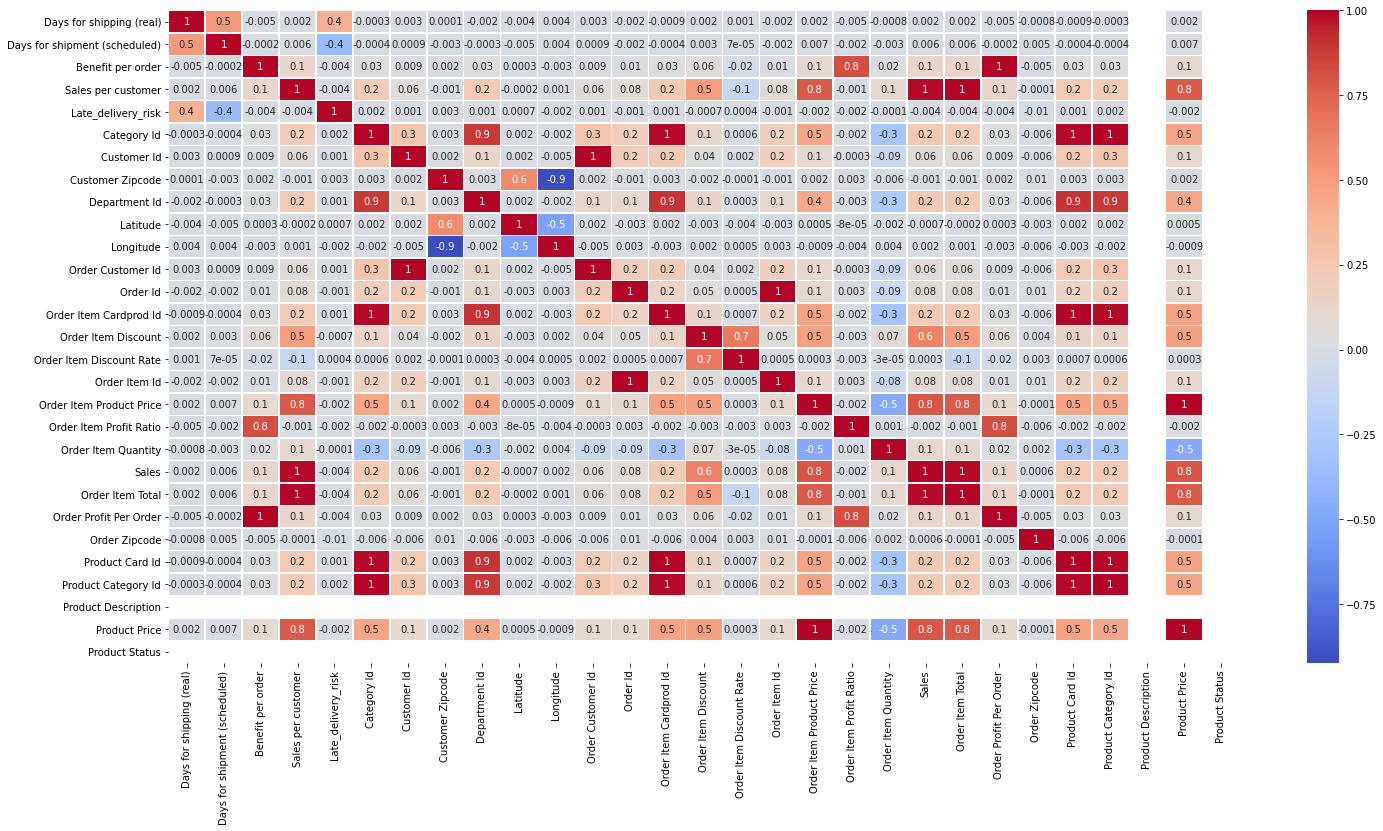

In [14]:
# Heatmap for correlation matrix
fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(dataset.corr(), annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm') # Heatmap for correlation matrix

## [Selection of Features](https://docs.google.com/spreadsheets/d/1zg9H_xDNFlVJODjMoJ6krk17a-CKIjUSx59TFuMwuns/edit?usp=sharing)

## Transformations

In [15]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

In [16]:
dataset['order_longitude'] = 1000
dataset['order_latitude'] = 1000

In [19]:
# To find the lattitude and logitude from Order_State
for city in dataset["Order State"].unique():
  try:
    location = geolocator.geocode(city)
    dataset.loc[dataset["Order State"]==city, ['order_longitude']] = location.longitude
    dataset.loc[dataset["Order State"]==city, ['order_latitude']] = location.latitude
  except:
    print(city)

print("\n\nCould not retrieve coordinates for {} records.".format(sum(dataset['order_longitude']==1000)))

Alsacia-Champaña-Ardenas-Lorena
Gobolka Woqooyi Galbeed
Garb-Chrarda-Beni Hsen
Fez-Bulmán
Rabat-Salé-Zemur-Zaer
Marrakech-Tensift-Al Hauz
Mar Rojo
Lagos
Zambezia
Languedoc-Rosellón-Mediodía-Pirineos
Centro-Valle de Loira
Finlandia del Sudoeste
Mindanao Septentrional
Chauía-Uardiga
Taza-Alhucemas-Taunat
Célebes Suroriental
Tasmania
Markazí
Eskisehir
Jambi
Ankara
Shanxi
Fukui
Basora
Waikato
Almaty
Ajmán
Gyeonggi
Nelson
Jiangxi
Chongqing
Jaiber Pajtunjuá
Nom Pen
Tamil Nadu
Perak
Sumatra Meridional
Cuscatlán
Kabul
Oklahoma
Kaduna
Kampala
Ríos
Níger
Constantina
Renania-Palatinado
Mykolayiv
Calabria
Mecklemburgo-Pomerania Occidental
Vilna
Timis
Berna
Borgoña-Franco Condado
Budapest
Navarra
Corse
Región Capital
Porto
Gales
Drenthe
Amur
Värmland
Salzburgo
Salta
Quezaltenango
Islas Baleares
Sumy
Bacau
Th? Dô Hà N?i
Uttarakhand
Kashkadar
Sistán y Baluchistán
Aichi
Trengganu
Kerala
Muharraq
Maryland
Flanders Oriental
Kumanovo
Overijssel
Dinamarca Meridional
Kaliningrado
Grad Zagreb
Frisia
Stávrop

In [20]:
dataset = dataset[dataset['order_longitude']<1000]
dataset = dataset.reset_index(drop=True)

In [21]:
'''
    Function to find distance from lattitude and longitude
    Args:
    lat1: lattitude corresponding to destination city of order
    lat2: lattitude corresponding to location of store
    long1: longitude corresponding to destination city of order
    long2: logitude corresponding to location of store
    
    Returns: distance
'''
def distance(lat1, lat2, long1, long2):
  radius = 6371
  rad = 3.14/180
  phi1 = lat1 * rad
  phi2 = lat2 * rad
  del_phi = (lat2-lat1)*rad
  del_lam = (long2-long1)*rad
  a = Math.sin(del_phi/2) * Math.sin(del_phi/2) + Math.cos(phi1)*Math.cos(phi2)*Math.sin(del_lam/2)*Math.sin(del_lam/2)
  return 2*radius*Math.atan2(Math.sqrt(a), Math.sqrt(1-a))

In [22]:
dataset["dist"] = -1
dataset["dist"] = dataset.apply(lambda x: distance(x.order_latitude, x.Latitude,
                                                   x.order_longitude, x.Longitude), axis=1)

In [25]:
# Find the shipping duration in hours by sustracting shipping_date__DateOrders_ and order_date__DateOrders_
dataset['shipping_duration']=0
dataset['shipping date (DateOrders)']=pd.to_datetime(dataset['shipping date (DateOrders)'])
dataset['order date (DateOrders)']=pd.to_datetime(dataset['order date (DateOrders)'])
for i in range(len(dataset)):
    deliv_date = dataset['shipping date (DateOrders)'][i]
    order_date = dataset['order date (DateOrders)'][i]
    time_delta = (deliv_date-order_date)
    dataset['shipping_duration'].iloc[i] = time_delta.days*24+time_delta.seconds/3600

<ipython-input-25-2f376e4c79c6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['shipping_duration'].iloc[i] = time_delta.days*24+time_delta.seconds/3600


Text(0, 0.5, 'Shipping duration hours')

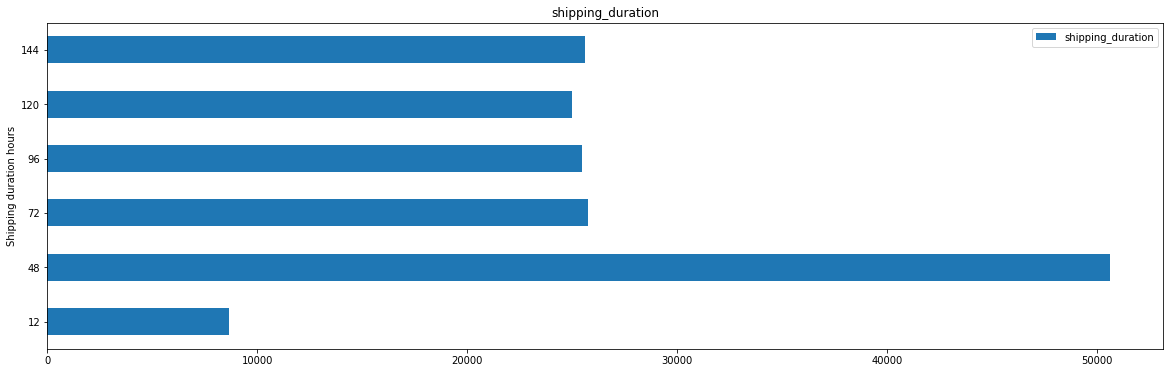

In [47]:
dataset['shipping_duration'].value_counts().reset_index(drop=False).sort_values(by='index').plot(kind = 'barh',x='index', y='shipping_duration',title='shipping_duration',figsize=(20,6))
plt.ylabel('Shipping duration hours')

## Datasets Export

In [19]:
# dataset = dataset.sample(frac=1).reset_index(drop=True)
# dataset.to_csv("./dataset_transformed.csv", index=False)

In [48]:
# Load transformed data from bigquery
# bqclient = bigquery.Client()
# query_string = "SELECT * FROM `ma-science-rd-vertex-ai.supply_chain_data.transformed_data`"

# dataset = (
#     bqclient.query(query_string)
#     .result()
#     .to_dataframe(
#         create_bqstorage_client=True,
#     )
# )

In [51]:
dataset.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [54]:
# Columns required for regression problem
reg_columns = ['Order Item Id', 'Type', 'Benefit per order', 'Sales per customer', 'Late_delivery_risk', 
               'Category Name', 'Customer Segment', 'Order Item Discount Rate', 'Order Item Product Price',
               'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Status',
               'Product Price', 'Shipping Mode', 'dist', 'shipping_duration']

In [55]:
regression_data = dataset[reg_columns]

In [56]:
regression_data.columns = ["order_item_id", "payment_type", "benefit_per_order", "sales_per_customer", 
           "late_delivery_risk", "category_name", "customer_segment", "order_item_discount_rate", 
           "order_item_product_price", "order_item_profit_ratio", "order_item_quantity", "sales",
           "order_item_total", "order_status", "product_price","shipping_mode", "distance", "shipping_duration"]

In [57]:
regression_data

,order_item_id,payment_type,benefit_per_order,sales_per_customer,late_delivery_risk,category_name,customer_segment,order_item_discount_rate,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_status,product_price,shipping_mode,distance,shipping_duration
0,180517,DEBIT,91.250000,314.640015,0,Sporting Goods,Consumer,0.04,327.750000,0.29,1,327.750000,314.640015,COMPLETE,327.750000,Standard Class,18573.960367,72
1,179254,TRANSFER,-249.089996,311.359985,1,Sporting Goods,Consumer,0.05,327.750000,-0.80,1,327.750000,311.359985,PENDING,327.750000,Standard Class,13383.510161,120
2,179253,CASH,-247.779999,309.720001,0,Sporting Goods,Consumer,0.06,327.750000,-0.80,1,327.750000,309.720001,CLOSED,327.750000,Standard Class,12707.850023,96
3,179252,DEBIT,22.860001,304.809998,0,Sporting Goods,Home Office,0.07,327.750000,0.08,1,327.750000,304.809998,COMPLETE,327.750000,Standard Class,12004.494304,72
4,179251,PAYMENT,134.210007,298.250000,0,Sporting Goods,Corporate,0.09,327.750000,0.45,1,327.750000,298.250000,PENDING_PAYMENT,327.750000,Standard Class,16806.575321,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161066,65185,PAYMENT,119.989998,299.989990,0,Fishing,Home Office,0.25,399.980011,0.40,1,399.980011,299.989990,PENDING_PAYMENT,399.980011,Standard Class,11751.234182,72
161067,65177,CASH,40.000000,399.980011,0,Fishing,Home Office,0.00,399.980011,0.10,1,399.980011,399.980011,CLOSED,399.980011,Standard Class,11873.273513,96
161068,65161,DEBIT,-613.770019,395.980011,1,Fishing,Corporate,0.01,399.980011,-1.55,1,399.980011,395.980011,COMPLETE,399.980011,Second Class,9062.872069,72
161069,65129,TRANSFER,141.110001,391.980011,1,Fishing,Corporate,0.02,399.980011,0.36,1,399.980011,391.980011,PENDING,399.980011,Standard Class,8733.916280,120


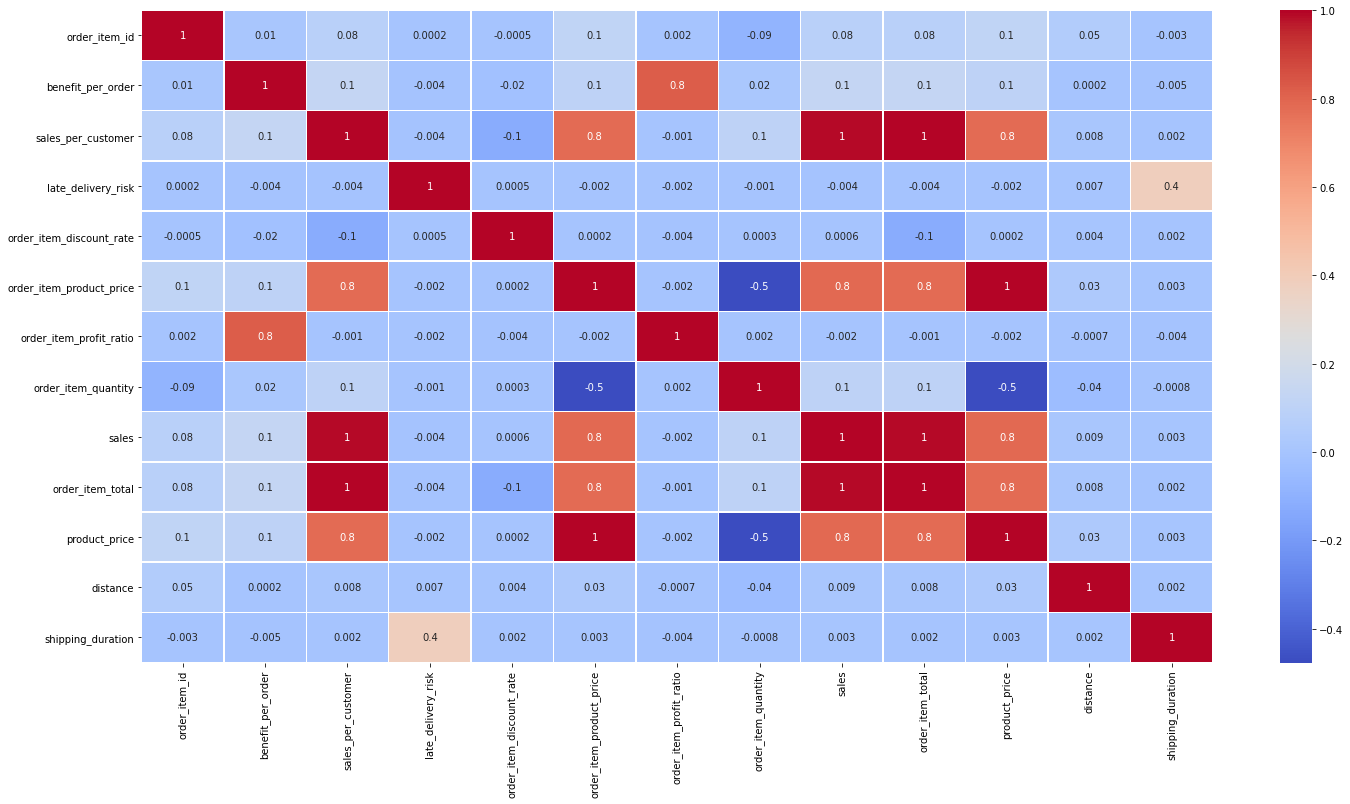

In [58]:
# Heatmap for correlation matrix corresponding to regression data
fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(regression_data.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm') # Heatmap for correlation matrix

In [74]:
#Function to convert the categorical columns into numeric
def Labelencoder_feature(x):
    le=LabelEncoder()
    x=le.fit_transform(x)
    return x

In [87]:
# regression modeling
regression_data_model=regression_data
features=["payment_type", "benefit_per_order", "sales_per_customer", "late_delivery_risk", "category_name", "customer_segment", "order_item_discount_rate", 
           "order_item_product_price", "order_item_profit_ratio", "order_item_quantity", "sales",
           "order_item_total", "order_status", "product_price","shipping_mode", "distance"]
target=['shipping_duration']

# Encoding the categorical features in the training data
cat_col = list(regression_data_model.select_dtypes(include=['object']).columns)

for col in cat_col:
    regression_data_model[col] = Labelencoder_feature(regression_data_model[col])
    
regression_data_model.head()

,order_item_id,payment_type,benefit_per_order,sales_per_customer,late_delivery_risk,category_name,customer_segment,order_item_discount_rate,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_status,product_price,shipping_mode,distance,shipping_duration
0,180517,1,91.250000,314.640015,0,40,0,0.04,327.75,0.29,1,327.75,314.640015,2,327.75,3,18573.960367,72
1,179254,3,-249.089996,311.359985,1,40,0,0.05,327.75,-0.80,1,327.75,311.359985,5,327.75,3,13383.510161,120
2,179253,0,-247.779999,309.720001,0,40,0,0.06,327.75,-0.80,1,327.75,309.720001,1,327.75,3,12707.850023,96
3,179252,1,22.860001,304.809998,0,40,2,0.07,327.75,0.08,1,327.75,304.809998,2,327.75,3,12004.494304,72
4,179251,2,134.210007,298.250000,0,40,1,0.09,327.75,0.45,1,327.75,298.250000,6,327.75,3,16806.575321,48


In [88]:
X=regression_data_model[features]
y=regression_data_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3) 
lgbr = LGBMRegressor(random_state = 42, learning_rate = 0.01 , boosting = 'gbdt', max_depth = 6,n_estimators = 600, reg_lambda=0.02, reg_alpha=0.01,num_leaves=4200 )
lgbr.fit(X_train, y_train)
#test data performance
y_true=y_test
y_pred=lgbr.predict(X_test)
rmse=mean_squared_error(y_true, y_pred, squared=False)
rsq=r2_score(y_true, y_pred)
bias=np.mean(y_pred-np.array(y_true['shipping_duration']))
mae=mean_absolute_error(y_true, y_pred)

print(rmse, rsq, bias, mae)

17.563118201284077 0.7958266603799244 0.08529546021563529 12.847765063695142


In [61]:
# Columns required for classificatopn problem
class_columns = ['Order Item Id', 'Type', 'Days for shipment (scheduled)', 'Sales per customer','Delivery Status' ,'Late_delivery_risk', 
               'Category Name', 'Customer Segment', 'Order Item Discount', 'Order Item Product Price',
                'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Status',
               'Product Price', 'Shipping Mode', 'dist', 'shipping_duration','Benefit per order']

In [62]:
classification_data = dataset[class_columns]

In [63]:
classification_data.columns = ["order_item_id", "payment_type", "estimate_days", "sales_per_customer", 
           "delivery_status", "late_delivery_risk", "category_name", "customer_segment", "order_item_discount",
           "order_item_product_price", "order_item_quantity", "sales", "order_item_total", "order_status", 
           "product_price", "shipping_mode","distance", "shipping_duration", "benefit_per_order"]

In [64]:
# Replace values of benefit_per_order with one and zero
classification_data['benefit_per_order'] = classification_data['benefit_per_order'].apply(lambda x: 1 if x>0 else 0)

<ipython-input-64-1d4ec5a47bfc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_data['benefit_per_order'] = classification_data['benefit_per_order'].apply(lambda x: 1 if x>0 else 0)


In [65]:
classification_data

,order_item_id,payment_type,estimate_days,sales_per_customer,delivery_status,late_delivery_risk,category_name,customer_segment,order_item_discount,order_item_product_price,order_item_quantity,sales,order_item_total,order_status,product_price,shipping_mode,distance,shipping_duration,benefit_per_order
0,180517,DEBIT,4,314.640015,Advance shipping,0,Sporting Goods,Consumer,13.110000,327.750000,1,327.750000,314.640015,COMPLETE,327.750000,Standard Class,18573.960367,72,1
1,179254,TRANSFER,4,311.359985,Late delivery,1,Sporting Goods,Consumer,16.389999,327.750000,1,327.750000,311.359985,PENDING,327.750000,Standard Class,13383.510161,120,0
2,179253,CASH,4,309.720001,Shipping on time,0,Sporting Goods,Consumer,18.030001,327.750000,1,327.750000,309.720001,CLOSED,327.750000,Standard Class,12707.850023,96,0
3,179252,DEBIT,4,304.809998,Advance shipping,0,Sporting Goods,Home Office,22.940001,327.750000,1,327.750000,304.809998,COMPLETE,327.750000,Standard Class,12004.494304,72,1
4,179251,PAYMENT,4,298.250000,Advance shipping,0,Sporting Goods,Corporate,29.500000,327.750000,1,327.750000,298.250000,PENDING_PAYMENT,327.750000,Standard Class,16806.575321,48,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161066,65185,PAYMENT,4,299.989990,Advance shipping,0,Fishing,Home Office,100.000000,399.980011,1,399.980011,299.989990,PENDING_PAYMENT,399.980011,Standard Class,11751.234182,72,1
161067,65177,CASH,4,399.980011,Shipping on time,0,Fishing,Home Office,0.000000,399.980011,1,399.980011,399.980011,CLOSED,399.980011,Standard Class,11873.273513,96,1
161068,65161,DEBIT,2,395.980011,Late delivery,1,Fishing,Corporate,4.000000,399.980011,1,399.980011,395.980011,COMPLETE,399.980011,Second Class,9062.872069,72,0
161069,65129,TRANSFER,4,391.980011,Late delivery,1,Fishing,Corporate,8.000000,399.980011,1,399.980011,391.980011,PENDING,399.980011,Standard Class,8733.916280,120,1


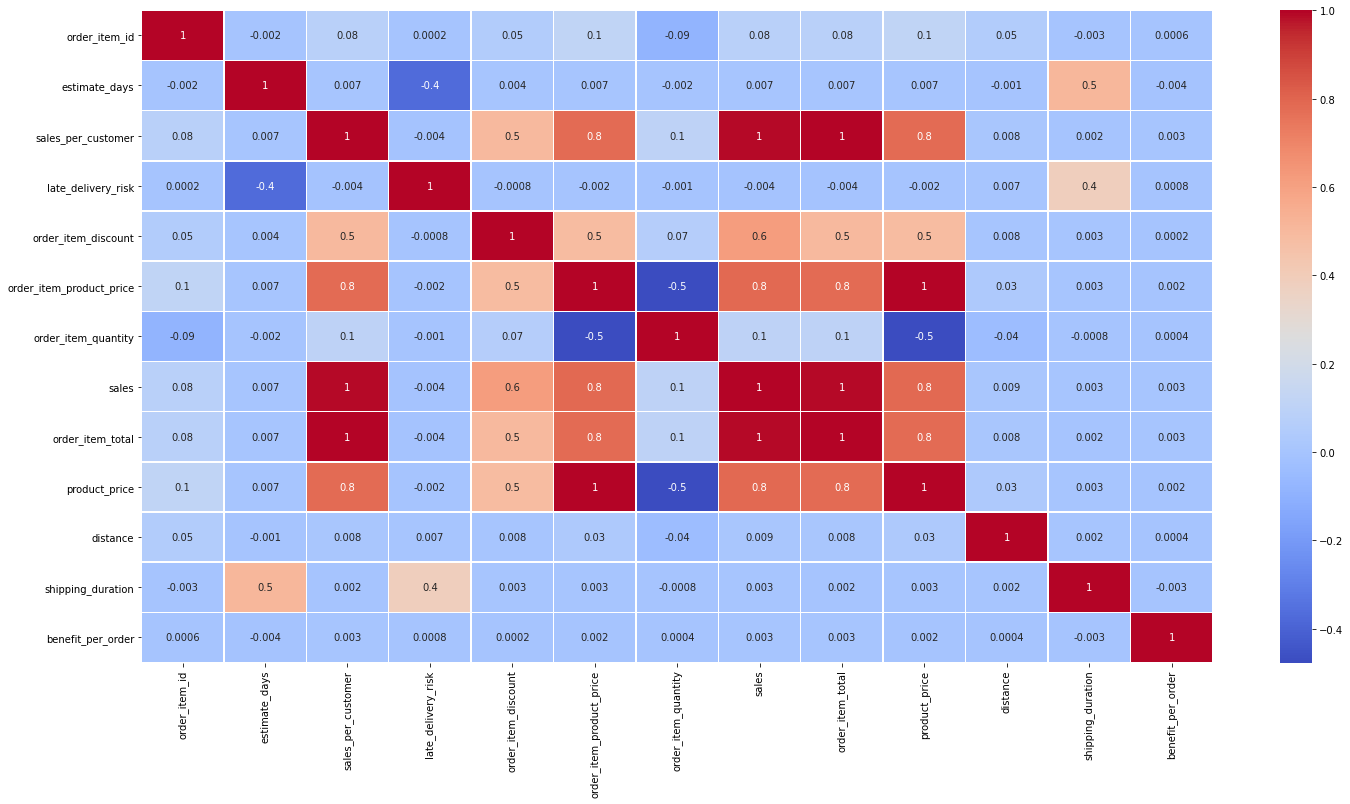

In [66]:
# Heatmap for correlation matrix corresponding to classifcation data
fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(classification_data.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm') # Heatmap for correlation matrix

In [91]:
# classification model
# regression modeling
classification_data_model=classification_data
features=["payment_type", "estimate_days", "sales_per_customer", 
           "delivery_status", "late_delivery_risk", "category_name", "customer_segment", "order_item_discount",
           "order_item_product_price", "order_item_quantity", "sales", "order_item_total", "order_status", 
           "product_price", "shipping_mode","distance"]
target=['benefit_per_order']

# Encoding the categorical features in the training data
cat_col = list(classification_data_model.select_dtypes(include=['object']).columns)
for col in cat_col:
    classification_data_model[col] = Labelencoder_feature(classification_data_model[col])
    
classification_data_model.head()

,order_item_id,payment_type,estimate_days,sales_per_customer,delivery_status,late_delivery_risk,category_name,customer_segment,order_item_discount,order_item_product_price,order_item_quantity,sales,order_item_total,order_status,product_price,shipping_mode,distance,shipping_duration,benefit_per_order
0,180517,1,4,314.640015,0,0,40,0,13.110000,327.75,1,327.75,314.640015,2,327.75,3,18573.960367,72,1
1,179254,3,4,311.359985,1,1,40,0,16.389999,327.75,1,327.75,311.359985,5,327.75,3,13383.510161,120,0
2,179253,0,4,309.720001,3,0,40,0,18.030001,327.75,1,327.75,309.720001,1,327.75,3,12707.850023,96,0
3,179252,1,4,304.809998,0,0,40,2,22.940001,327.75,1,327.75,304.809998,2,327.75,3,12004.494304,72,1
4,179251,2,4,298.250000,0,0,40,1,29.500000,327.75,1,327.75,298.250000,6,327.75,3,16806.575321,48,1


In [101]:
classification_data_model['benefit_per_order'].value_counts(normalize=True)

1    0.806048
0    0.193952
Name: benefit_per_order, dtype: float64

/Users/kpathak/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kpathak/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.27      0.00      0.00      9265
           1       0.81      1.00      0.89     39057

    accuracy                           0.81     48322
   macro avg       0.54      0.50      0.45     48322
weighted avg       0.70      0.81      0.72     48322

0.5002095778733784


/Users/kpathak/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


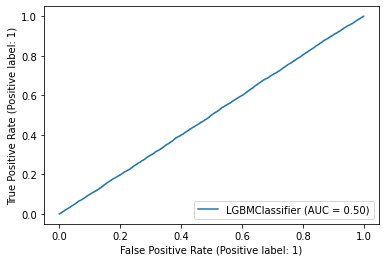

In [99]:
X=classification_data_model[features]
y=classification_data_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3) 
lgbc=LGBMClassifier(n_estimators=500)
lgbc.fit(X_train, y_train)
#test data performance
y_true=y_test
y_pred=lgbc.predict(X_test)

print(classification_report(np.array(y_true['benefit_per_order']),y_pred))
print(roc_auc_score(y_true,y_pred))
plot_roc_curve(lgbc, X_test, y_test) 


In [ ]:
# add some sampling strategy to imporve 